# Milestone 4: Couette Flow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import src.simulation as sim
import src.boundary as bdry
from scipy.special import lambertw

## Parameters

In [2]:
size_x = 100
size_y = 100
n_steps = 50000
omega = 1.0
wall_velocity = 1.0

## Initialize

In [3]:
lattice = sim.LatticeBoltzmann(size_x, size_y, omega=omega, init_density=np.ones((size_y, size_x)),
                               boundaries=[bdry.MovingWallBoundaryCondition("t", [0, wall_velocity]),
                                           bdry.RigidWallBoundaryCondition("b")],
                               plot=False, animate=False)

## Run Simulation and take Measurements

In [4]:
velocity_field = np.empty((n_steps+1, size_y, size_x))
velocity_field[0] = lattice.velocity[1]
for i in range(n_steps):
    lattice.step()
    velocity_field[i+1] = lattice.velocity[1]

## Plot Results

### Evolution of the Velocity Profile

Analytical solution: $u_x(\cdot, y) = \frac{Y-y}{Y} U_w$

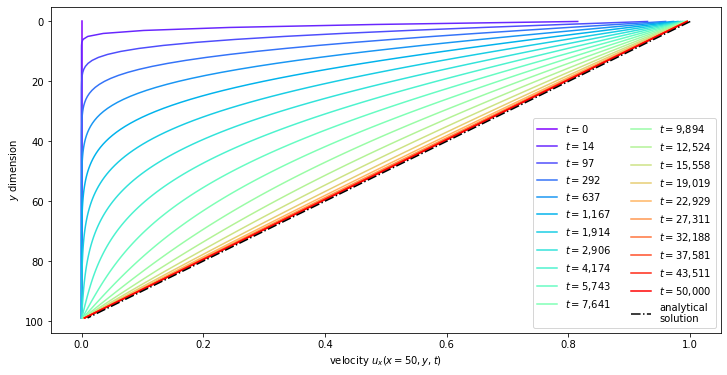

In [5]:
measurement_point = size_x//2
fig, ax = plt.subplots(figsize=(12, 6))
ax.invert_yaxis()
ax.set_xlabel(f"velocity $u_x(x={measurement_point}, y, t)$")
ax.set_ylabel("$y$ dimension")
# steps with exponentially increasing step size
# solve n_steps^(1/b)/b=20 for b to plot exactly 20 steps --> 20 + last = 21 lines
b = np.log(n_steps) / lambertw(20 * np.log(n_steps)).real + 1e-12
steps = np.append((np.arange(np.power(n_steps, 1/b), step=b)**b).astype(int), n_steps)
y_data = np.arange(size_y)
for t in steps:
    x_data = velocity_field[t, :, measurement_point]
    ax.plot(x_data, y_data, color=plt.cm.rainbow(np.power(t/n_steps, 1/b)), label=f"$t=${t:,}")
ax.plot(np.flip((y_data+1)/size_y*wall_velocity), y_data, "k-.", label="analytical\nsolution")
ax.legend(ncol=2)
plt.show()

### Flow Field/Streamlines

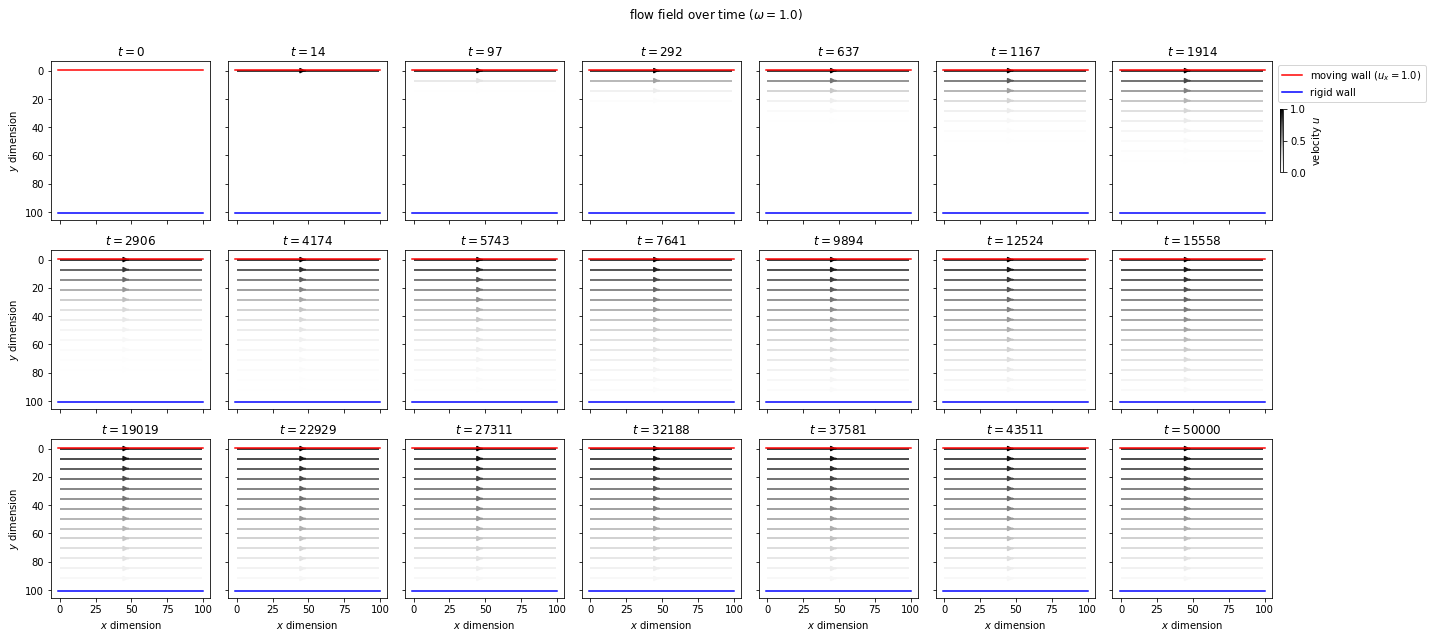

In [7]:
n_cols = 7
n_rows = len(steps) // n_cols
fig, ax = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(20, 21*(n_rows/n_cols)))
fig.suptitle(f"flow field over time ($\omega = {omega}$)\n")
axf = ax.flatten()
axf[0].invert_yaxis()
x, y, v = np.arange(size_x), np.arange(size_y), np.zeros((size_y, size_y))
for i, t in enumerate(steps):
    axf[i].set_title(f"$t={t}$")
    if i % n_cols == 0:
        axf[i].set_ylabel("$y$ dimension")
    if i >= n_cols*(n_rows-1):
        axf[i].set_xlabel("$x$ dimension")
    if i > 0:  # streamplot cannot handle u=0 at t=0
        u = velocity_field[t]
        axf[i].streamplot(x, y, u, v, density=0.5, color=u, cmap=plt.cm.Greys)
    axf[i].plot([-1, size_x], [-0.5, -0.5], color="red", label=f"moving wall ($u_x={wall_velocity}$)")
    axf[i].plot([-1, size_x], [size_y+0.5, size_y+0.5], color="blue", label="rigid wall")
axf[n_cols-1].legend(bbox_to_anchor=(1.01, 1.01))
fig.tight_layout()
p = axf[n_cols-1].get_position()
fig.colorbar(plt.cm.ScalarMappable(plt.Normalize(0.0, wall_velocity), plt.cm.Greys),
             ax=fig.add_axes([p.x0+0.2*p.width, p.y0, p.width, p.height], visible=False),
             shrink=0.4, ticks=[0.0, wall_velocity/2, wall_velocity], label="velocity $u$")
plt.show()